In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
with open('DataSplit.pickle', 'rb') as handle:
    DataSplit = pickle.load(handle)

In [3]:
# Hyperparameters
train_batch_size = 10
val_batch_size = 10
learning_rate = 0.0001
num_epochs = 200

In [4]:
class Senz3DDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels
        self.GT_labels = {'1': 5, '2': 2, '3': 3, '4': 5, '5': 0, '6': 2, 
                          '7': 1, '8': 4, '9': 3, '10': 1, '11': 1}
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = cv2.imread("..\\." + self.paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img.shape[1]//4, img.shape[0]//4)).astype(np.uint8)
        
        label = torch.tensor(self.GT_labels[(self.labels[idx])])
        
        return {'img': img, 'label': label}

In [5]:
# Make Datasets
TrainDataset = Senz3DDataset(list(DataSplit['train'].keys()), list(DataSplit['train'].values()))
ValDataset = Senz3DDataset(list(DataSplit['val'].keys()), list(DataSplit['val'].values()))
TestDataset = Senz3DDataset(list(DataSplit['test'].keys()), list(DataSplit['test'].values()))

In [6]:
#  Make DataLoaders
TrainDataLoader = DataLoader(TrainDataset, batch_size=train_batch_size, shuffle=True)
ValDataLoader = DataLoader(ValDataset, batch_size=val_batch_size, shuffle=True)
TestDataLoader = DataLoader(TestDataset, batch_size=1, shuffle=False)

In [7]:
import torchvision.models as models
model_name = 'resnet152'
model = models.resnet152(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 64),
    nn.ReLU(),
    nn.Linear(64,6),
    nn.Softmax(dim=1),    
    )

for i, param in enumerate(model.parameters()):
    if i < 465:
      print(f'Layer{i} frozen:', type(param), param.size())
      param.requires_grad = False
    else: 
      print(f'Layer{i} not frozen', type(param), param.size())
      param.requires_grad = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_metric = nn.CrossEntropyLoss()

Layer0 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 7, 7])
Layer1 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer2 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer3 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 1, 1])
Layer4 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer5 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer6 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 3, 3])
Layer7 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer8 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([64])
Layer9 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256, 64, 1, 1])
Layer10 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256])
Layer11 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256])
Layer12 frozen: <class 'torch.nn.parameter.Parameter'> torch.Size([256, 64, 1, 1])
Layer13 frozen: <clas

In [8]:
# Initialize
epoch_train_loss = []
epoch_train_accuracy = []

epoch_val_loss = []
epoch_val_accuracy = []

epoch_test_loss = []
epoch_test_accuracy = []

best_val_accuracy = 0

for epic in range(num_epochs):
    
    # Put model in training mode
    model.train()
    
    train_correct = 0
    train_total = 0
    train_loss = 0
    
    for i, sample in tqdm.tqdm(enumerate(TrainDataLoader)):
        
        # move inputs to device
        if torch.cuda.is_available():
            x = sample['img'].permute(0, 3, 1, 2).float().to(device)
            y = sample['label'].to(device)
        
        # Loop over model, calculate loss
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_metric(output, y)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy/loss
        _, y_hat = torch.max(output, dim=1)
        
        train_correct += torch.sum(y_hat == y)
        train_total += x.shape[0]
        train_loss += loss.item() * x.shape[0]
        
    # Append to epoch loss/accuracy
    epoch_train_loss.append(train_loss / train_total)
    epoch_train_accuracy.append(train_correct.float() / train_total)
    
    print(f'Epoch: {epic}, Train Loss: {epoch_train_loss[-1]}, Train Acc: {epoch_train_accuracy[-1]}')
    
    # Put model in validation mode
    model.eval()
    
    val_total = 0
    val_correct = 0
    val_loss = 0
    
    with torch.no_grad():
        for i, sample in enumerate(ValDataLoader):
            
            # move inputs to device
            if torch.cuda.is_available():
                x = sample['img'].permute(0, 3, 1, 2).float().to(device)
                y = sample['label'].to(device)

            output = model.forward(x)
            loss = loss_metric(output, y)
            
            # Calculate accuracy/loss
            _, y_hat = torch.max(output, dim=1)
            batch_correct = torch.sum(y_hat == y)
            val_correct += torch.sum(y_hat == y)
            val_total += x.shape[0]
            val_loss += loss.item() * x.shape[0]
            
    # Append to epoch loss/accuracy
    epoch_val_loss.append(val_loss / val_total)
    val_accuracy = val_correct.float() / val_total
    epoch_val_accuracy.append(val_accuracy)
    
    if val_accuracy > best_val_accuracy:
        print("Saved new best model.")
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), f'saved_models/{model_name}.pth')
    
    print(f'Epoch: {epic}, Val Loss: {epoch_val_loss[-1]}, Val Acc: {epoch_val_accuracy[-1]}')
    
    

97it [00:45,  2.11it/s]


Epoch: 0, Train Loss: 1.748520582388247, Train Acc: 0.26998963952064514
Saved new best model.


0it [00:00, ?it/s]

Epoch: 0, Val Loss: 1.7276385705248058, Val Acc: 0.2949640452861786


97it [00:19,  4.87it/s]


Epoch: 1, Train Loss: 1.6576203185821248, Train Acc: 0.39667707681655884
Saved new best model.


0it [00:00, ?it/s]

Epoch: 1, Val Loss: 1.6622271417713852, Val Acc: 0.3741007149219513


97it [00:19,  4.94it/s]


Epoch: 2, Train Loss: 1.6083789645449518, Train Acc: 0.4340602457523346
Saved new best model.


0it [00:00, ?it/s]

Epoch: 2, Val Loss: 1.6063733666920834, Val Acc: 0.4460431635379791


97it [00:19,  4.93it/s]


Epoch: 3, Train Loss: 1.5865592876079793, Train Acc: 0.45379024744033813
Saved new best model.


0it [00:00, ?it/s]

Epoch: 3, Val Loss: 1.5846968494730889, Val Acc: 0.47482016682624817


97it [00:19,  4.90it/s]


Epoch: 4, Train Loss: 1.538822551135086, Train Acc: 0.5223261117935181
Saved new best model.


0it [00:00, ?it/s]

Epoch: 4, Val Loss: 1.5504894556759072, Val Acc: 0.49640288949012756


97it [00:19,  4.99it/s]


Epoch: 5, Train Loss: 1.5310191329518335, Train Acc: 0.5067497491836548


0it [00:00, ?it/s]

Epoch: 5, Val Loss: 1.555440833242677, Val Acc: 0.4892086386680603


97it [00:19,  5.04it/s]


Epoch: 6, Train Loss: 1.5159394127062424, Train Acc: 0.5285566449165344


0it [00:00, ?it/s]

Epoch: 6, Val Loss: 1.5579397712680076, Val Acc: 0.47482016682624817


97it [00:18,  5.11it/s]


Epoch: 7, Train Loss: 1.498859375065361, Train Acc: 0.5430945158004761


0it [00:00, ?it/s]

Epoch: 7, Val Loss: 1.5282919518381572, Val Acc: 0.49640288949012756


97it [00:18,  5.23it/s]


Epoch: 8, Train Loss: 1.4879793864544306, Train Acc: 0.5545171499252319


0it [00:00, ?it/s]

Epoch: 8, Val Loss: 1.5492112662294786, Val Acc: 0.49640288949012756


97it [00:18,  5.23it/s]


Epoch: 9, Train Loss: 1.4801316011236711, Train Acc: 0.5565940141677856


0it [00:00, ?it/s]

Epoch: 9, Val Loss: 1.5204931300321072, Val Acc: 0.49640288949012756


97it [00:18,  5.23it/s]


Epoch: 10, Train Loss: 1.4728436718848636, Train Acc: 0.5721703171730042
Saved new best model.


0it [00:00, ?it/s]

Epoch: 10, Val Loss: 1.4800621296862047, Val Acc: 0.5827338099479675


97it [00:18,  5.16it/s]


Epoch: 11, Train Loss: 1.4480433244942876, Train Acc: 0.5991693139076233


0it [00:00, ?it/s]

Epoch: 11, Val Loss: 1.4767346450750776, Val Acc: 0.5755395889282227


97it [00:18,  5.22it/s]


Epoch: 12, Train Loss: 1.4194076371960427, Train Acc: 0.6313603520393372
Saved new best model.


0it [00:00, ?it/s]

Epoch: 12, Val Loss: 1.4043939705375288, Val Acc: 0.6546762585639954


97it [00:19,  4.96it/s]


Epoch: 13, Train Loss: 1.3779187963759045, Train Acc: 0.6791277527809143
Saved new best model.


0it [00:00, ?it/s]

Epoch: 13, Val Loss: 1.3760456464273467, Val Acc: 0.6762589812278748


97it [00:19,  5.01it/s]


Epoch: 14, Train Loss: 1.3788366138254247, Train Acc: 0.6708203554153442
Saved new best model.


0it [00:00, ?it/s]

Epoch: 14, Val Loss: 1.352962710016923, Val Acc: 0.6978417634963989


97it [00:19,  4.98it/s]


Epoch: 15, Train Loss: 1.384452099493112, Train Acc: 0.672897219657898
Saved new best model.


0it [00:00, ?it/s]

Epoch: 15, Val Loss: 1.3500090194263046, Val Acc: 0.7050359845161438


97it [00:18,  5.11it/s]


Epoch: 16, Train Loss: 1.3460458474986154, Train Acc: 0.7071651220321655


0it [00:00, ?it/s]

Epoch: 16, Val Loss: 1.3650391427733057, Val Acc: 0.6906474828720093


97it [00:18,  5.13it/s]


Epoch: 17, Train Loss: 1.331483970921359, Train Acc: 0.721703052520752
Saved new best model.


0it [00:00, ?it/s]

Epoch: 17, Val Loss: 1.2939059802954145, Val Acc: 0.7625899314880371


97it [00:19,  5.10it/s]


Epoch: 18, Train Loss: 1.3188686805350758, Train Acc: 0.7258567214012146


0it [00:00, ?it/s]

Epoch: 18, Val Loss: 1.3327940839657682, Val Acc: 0.7410072088241577


97it [00:19,  5.08it/s]


Epoch: 19, Train Loss: 1.3283489363215795, Train Acc: 0.7237798571586609


0it [00:00, ?it/s]

Epoch: 19, Val Loss: 1.306151785438867, Val Acc: 0.7266187071800232


97it [00:19,  5.06it/s]


Epoch: 20, Train Loss: 1.3184408811022559, Train Acc: 0.7279335856437683


0it [00:00, ?it/s]

Epoch: 20, Val Loss: 1.3231350706635618, Val Acc: 0.7266187071800232


97it [00:19,  4.90it/s]


Epoch: 21, Train Loss: 1.318409345479274, Train Acc: 0.7352025508880615
Saved new best model.


0it [00:00, ?it/s]

Epoch: 21, Val Loss: 1.2568038213167259, Val Acc: 0.7841726541519165


97it [00:19,  4.95it/s]


Epoch: 22, Train Loss: 1.302758691095489, Train Acc: 0.7466251850128174
Saved new best model.


0it [00:00, ?it/s]

Epoch: 22, Val Loss: 1.2372351301659783, Val Acc: 0.8417266607284546


97it [00:19,  4.98it/s]


Epoch: 23, Train Loss: 1.2924943294604372, Train Acc: 0.7642783522605896


0it [00:00, ?it/s]

Epoch: 23, Val Loss: 1.2435510381520223, Val Acc: 0.8129496574401855


97it [00:19,  4.95it/s]


Epoch: 24, Train Loss: 1.2774458408108134, Train Acc: 0.7767394185066223
Saved new best model.


0it [00:00, ?it/s]

Epoch: 24, Val Loss: 1.2104666035809963, Val Acc: 0.8489208817481995


97it [00:19,  5.01it/s]


Epoch: 25, Train Loss: 1.2643087807721685, Train Acc: 0.7871236205101013


0it [00:00, ?it/s]

Epoch: 25, Val Loss: 1.2298390882478343, Val Acc: 0.8129496574401855


97it [00:19,  5.01it/s]


Epoch: 26, Train Loss: 1.248822129651641, Train Acc: 0.8110073208808899


0it [00:00, ?it/s]

Epoch: 26, Val Loss: 1.2193434821615974, Val Acc: 0.8345323801040649


97it [00:19,  5.01it/s]


Epoch: 27, Train Loss: 1.2416765367997151, Train Acc: 0.8058152198791504


0it [00:00, ?it/s]

Epoch: 27, Val Loss: 1.2655613774018322, Val Acc: 0.8057554364204407


97it [00:19,  5.01it/s]


Epoch: 28, Train Loss: 1.2476626473671426, Train Acc: 0.8047767877578735


0it [00:00, ?it/s]

Epoch: 28, Val Loss: 1.2538813438346919, Val Acc: 0.7913669347763062


97it [00:19,  5.01it/s]


Epoch: 29, Train Loss: 1.2251947114276984, Train Acc: 0.8265836238861084


0it [00:00, ?it/s]

Epoch: 29, Val Loss: 1.2173755014543053, Val Acc: 0.8345323801040649


97it [00:19,  4.96it/s]


Epoch: 30, Train Loss: 1.2262842525202908, Train Acc: 0.8234683871269226


0it [00:00, ?it/s]

Epoch: 30, Val Loss: 1.2163119753487677, Val Acc: 0.8345323801040649


97it [00:19,  5.02it/s]


Epoch: 31, Train Loss: 1.2108558425031841, Train Acc: 0.8369678258895874


0it [00:00, ?it/s]

Epoch: 31, Val Loss: 1.2125561837669756, Val Acc: 0.8201438784599304


97it [00:19,  4.96it/s]


Epoch: 32, Train Loss: 1.2503958445347978, Train Acc: 0.7964693903923035


0it [00:00, ?it/s]

Epoch: 32, Val Loss: 1.2153366829851548, Val Acc: 0.8201438784599304


97it [00:19,  5.01it/s]


Epoch: 33, Train Loss: 1.2136484034212456, Train Acc: 0.8338525891304016


0it [00:00, ?it/s]

Epoch: 33, Val Loss: 1.2114979714798413, Val Acc: 0.8417266607284546


97it [00:19,  4.97it/s]


Epoch: 34, Train Loss: 1.2316993307844502, Train Acc: 0.8224299550056458


0it [00:00, ?it/s]

Epoch: 34, Val Loss: 1.2149990728433184, Val Acc: 0.8201438784599304


97it [00:19,  5.00it/s]


Epoch: 35, Train Loss: 1.2220996912889888, Train Acc: 0.8286604881286621


0it [00:00, ?it/s]

Epoch: 35, Val Loss: 1.253988958091187, Val Acc: 0.7841726541519165


97it [00:19,  4.94it/s]


Epoch: 36, Train Loss: 1.2091230988378714, Train Acc: 0.8390446901321411


0it [00:00, ?it/s]

Epoch: 36, Val Loss: 1.2524008442172043, Val Acc: 0.7769784331321716


97it [00:19,  5.01it/s]


Epoch: 37, Train Loss: 1.215357433598361, Train Acc: 0.8380062580108643


0it [00:00, ?it/s]

Epoch: 37, Val Loss: 1.2234574702146241, Val Acc: 0.8201438784599304


97it [00:19,  5.01it/s]


Epoch: 38, Train Loss: 1.201220026268766, Train Acc: 0.8452752232551575


0it [00:00, ?it/s]

Epoch: 38, Val Loss: 1.2533209606897917, Val Acc: 0.7913669347763062


97it [00:19,  5.01it/s]


Epoch: 39, Train Loss: 1.2053240785222434, Train Acc: 0.840083122253418


0it [00:00, ?it/s]

Epoch: 39, Val Loss: 1.2001732544933292, Val Acc: 0.8489208817481995


97it [00:19,  5.01it/s]


Epoch: 40, Train Loss: 1.2100059900699747, Train Acc: 0.8348910212516785


0it [00:00, ?it/s]

Epoch: 40, Val Loss: 1.2152063160491504, Val Acc: 0.8273381590843201


97it [00:19,  4.97it/s]


Epoch: 41, Train Loss: 1.2044387972862425, Train Acc: 0.8390446901321411
Saved new best model.


0it [00:00, ?it/s]

Epoch: 41, Val Loss: 1.1856371867570945, Val Acc: 0.8561151027679443


97it [00:19,  4.92it/s]


Epoch: 42, Train Loss: 1.199485069123384, Train Acc: 0.8535826206207275


0it [00:00, ?it/s]

Epoch: 42, Val Loss: 1.2055699756677203, Val Acc: 0.8345323801040649


97it [00:19,  4.88it/s]


Epoch: 43, Train Loss: 1.195919034265655, Train Acc: 0.8515057563781738
Saved new best model.


0it [00:00, ?it/s]

Epoch: 43, Val Loss: 1.1850171295001353, Val Acc: 0.863309383392334


97it [00:20,  4.82it/s]


Epoch: 44, Train Loss: 1.216656651204744, Train Acc: 0.8328141570091248


0it [00:00, ?it/s]

Epoch: 44, Val Loss: 1.1919609291090383, Val Acc: 0.8489208817481995


97it [00:20,  4.79it/s]


Epoch: 45, Train Loss: 1.1848835531672461, Train Acc: 0.8577362895011902
Saved new best model.


0it [00:00, ?it/s]

Epoch: 45, Val Loss: 1.1659373362287342, Val Acc: 0.9064748287200928


97it [00:19,  4.86it/s]


Epoch: 46, Train Loss: 1.1851203264600887, Train Acc: 0.858774721622467


0it [00:00, ?it/s]

Epoch: 46, Val Loss: 1.1747351781927424, Val Acc: 0.8705036044120789


97it [00:20,  4.80it/s]


Epoch: 47, Train Loss: 1.1948004499278955, Train Acc: 0.8566978573799133
Saved new best model.


0it [00:00, ?it/s]

Epoch: 47, Val Loss: 1.148371918595952, Val Acc: 0.9136691093444824


97it [00:20,  4.79it/s]


Epoch: 48, Train Loss: 1.170430417001433, Train Acc: 0.879543125629425


0it [00:00, ?it/s]

Epoch: 48, Val Loss: 1.1727741879524944, Val Acc: 0.8848921060562134


97it [00:20,  4.80it/s]


Epoch: 49, Train Loss: 1.1909200762662562, Train Acc: 0.8598130941390991


0it [00:00, ?it/s]

Epoch: 49, Val Loss: 1.1849600685586175, Val Acc: 0.8705036044120789


97it [00:20,  4.80it/s]


Epoch: 50, Train Loss: 1.1997023481693843, Train Acc: 0.8546209931373596


0it [00:00, ?it/s]

Epoch: 50, Val Loss: 1.1510561953345648, Val Acc: 0.9064748287200928


97it [00:20,  4.83it/s]


Epoch: 51, Train Loss: 1.1889326433773972, Train Acc: 0.8515057563781738


0it [00:00, ?it/s]

Epoch: 51, Val Loss: 1.1553216212087398, Val Acc: 0.8992806077003479


97it [00:20,  4.80it/s]


Epoch: 52, Train Loss: 1.1684407076236492, Train Acc: 0.8857736587524414


0it [00:00, ?it/s]

Epoch: 52, Val Loss: 1.154135049675866, Val Acc: 0.8992806077003479


97it [00:20,  4.81it/s]


Epoch: 53, Train Loss: 1.1603131358621028, Train Acc: 0.8940810561180115
Saved new best model.


1it [00:00,  4.79it/s]

Epoch: 53, Val Loss: 1.1184429136111582, Val Acc: 0.9208633303642273


97it [00:20,  4.82it/s]


Epoch: 54, Train Loss: 1.140005407179875, Train Acc: 0.90965735912323


0it [00:00, ?it/s]

Epoch: 54, Val Loss: 1.1626670763646956, Val Acc: 0.8920863270759583


97it [00:20,  4.78it/s]


Epoch: 55, Train Loss: 1.1331603380997481, Train Acc: 0.9179647564888


0it [00:00, ?it/s]

Epoch: 55, Val Loss: 1.1463827366451564, Val Acc: 0.9064748287200928


97it [00:20,  4.80it/s]


Epoch: 56, Train Loss: 1.1451729102793264, Train Acc: 0.9044652581214905


0it [00:00, ?it/s]

Epoch: 56, Val Loss: 1.1325110025543104, Val Acc: 0.9208633303642273


97it [00:20,  4.74it/s]


Epoch: 57, Train Loss: 1.1300755116550845, Train Acc: 0.9169263243675232


0it [00:00, ?it/s]

Epoch: 57, Val Loss: 1.1307849120750701, Val Acc: 0.9136691093444824


97it [00:20,  4.75it/s]


Epoch: 58, Train Loss: 1.1238974408321043, Train Acc: 0.928348958492279
Saved new best model.


0it [00:00, ?it/s]

Epoch: 58, Val Loss: 1.112741171027259, Val Acc: 0.9424460530281067


97it [00:20,  4.79it/s]


Epoch: 59, Train Loss: 1.1205938372408986, Train Acc: 0.9345794916152954


0it [00:00, ?it/s]

Epoch: 59, Val Loss: 1.1252289101374235, Val Acc: 0.9352518320083618


97it [00:20,  4.82it/s]


Epoch: 60, Train Loss: 1.1238766647449783, Train Acc: 0.9221184253692627


0it [00:00, ?it/s]

Epoch: 60, Val Loss: 1.1389700345855822, Val Acc: 0.9136691093444824


97it [00:20,  4.83it/s]


Epoch: 61, Train Loss: 1.1112550192532882, Train Acc: 0.9366562962532043


0it [00:00, ?it/s]

Epoch: 61, Val Loss: 1.1058794337210895, Val Acc: 0.9424460530281067


97it [00:20,  4.80it/s]


Epoch: 62, Train Loss: 1.1211430582054431, Train Acc: 0.9262720942497253


0it [00:00, ?it/s]

Epoch: 62, Val Loss: 1.1104726165318661, Val Acc: 0.9352518320083618


97it [00:20,  4.79it/s]


Epoch: 63, Train Loss: 1.1153428605288607, Train Acc: 0.9397715926170349


0it [00:00, ?it/s]

Epoch: 63, Val Loss: 1.106700293451762, Val Acc: 0.9424460530281067


97it [00:20,  4.80it/s]


Epoch: 64, Train Loss: 1.1175585179314065, Train Acc: 0.9325026273727417


0it [00:00, ?it/s]

Epoch: 64, Val Loss: 1.1280095191310635, Val Acc: 0.9280575513839722


97it [00:20,  4.84it/s]


Epoch: 65, Train Loss: 1.1035483746266193, Train Acc: 0.9491173624992371


0it [00:00, ?it/s]

Epoch: 65, Val Loss: 1.110601164454179, Val Acc: 0.9352518320083618


97it [00:20,  4.83it/s]


Epoch: 66, Train Loss: 1.0993968736097943, Train Acc: 0.9553478956222534


0it [00:00, ?it/s]

Epoch: 66, Val Loss: 1.1258537100373411, Val Acc: 0.9208633303642273


97it [00:20,  4.80it/s]


Epoch: 67, Train Loss: 1.0925941479664107, Train Acc: 0.9532710909843445


0it [00:00, ?it/s]

Epoch: 67, Val Loss: 1.1584046435870712, Val Acc: 0.8776978850364685


97it [00:20,  4.83it/s]


Epoch: 68, Train Loss: 1.0879054718176029, Train Acc: 0.9605399966239929


0it [00:00, ?it/s]

Epoch: 68, Val Loss: 1.1222179853658882, Val Acc: 0.9280575513839722


97it [00:20,  4.79it/s]


Epoch: 69, Train Loss: 1.079235156005788, Train Acc: 0.9709242582321167


0it [00:00, ?it/s]

Epoch: 69, Val Loss: 1.1067022582609876, Val Acc: 0.9280575513839722


97it [00:20,  4.84it/s]


Epoch: 70, Train Loss: 1.095258144698534, Train Acc: 0.9501557946205139


0it [00:00, ?it/s]

Epoch: 70, Val Loss: 1.1252941845132292, Val Acc: 0.9280575513839722


97it [00:20,  4.83it/s]


Epoch: 71, Train Loss: 1.0978928841534434, Train Acc: 0.9543094635009766


0it [00:00, ?it/s]

Epoch: 71, Val Loss: 1.104036379203522, Val Acc: 0.9424460530281067


97it [00:20,  4.84it/s]


Epoch: 72, Train Loss: 1.0885315674240097, Train Acc: 0.9667705297470093


0it [00:00, ?it/s]

Epoch: 72, Val Loss: 1.108099253057576, Val Acc: 0.9352518320083618


97it [00:20,  4.84it/s]


Epoch: 73, Train Loss: 1.1016161855259912, Train Acc: 0.9460021257400513


0it [00:00, ?it/s]

Epoch: 73, Val Loss: 1.1120431466068295, Val Acc: 0.9424460530281067


97it [00:20,  4.82it/s]


Epoch: 74, Train Loss: 1.0809097666359146, Train Acc: 0.9709242582321167
Saved new best model.


0it [00:00, ?it/s]

Epoch: 74, Val Loss: 1.0943573516049832, Val Acc: 0.9568345546722412


97it [00:20,  4.77it/s]


Epoch: 75, Train Loss: 1.0789742451219173, Train Acc: 0.9709242582321167


0it [00:00, ?it/s]

Epoch: 75, Val Loss: 1.1402593628108073, Val Acc: 0.8920863270759583


97it [00:20,  4.81it/s]


Epoch: 76, Train Loss: 1.0723751389720357, Train Acc: 0.9771547913551331


0it [00:00, ?it/s]

Epoch: 76, Val Loss: 1.1283243500071465, Val Acc: 0.9136691093444824


97it [00:20,  4.79it/s]


Epoch: 77, Train Loss: 1.0879400758109483, Train Acc: 0.9574247598648071


0it [00:00, ?it/s]

Epoch: 77, Val Loss: 1.0980412171041365, Val Acc: 0.9496403336524963


97it [00:20,  4.81it/s]


Epoch: 78, Train Loss: 1.0890995594571313, Train Acc: 0.958463191986084


0it [00:00, ?it/s]

Epoch: 78, Val Loss: 1.1330157098152656, Val Acc: 0.9064748287200928


97it [00:20,  4.81it/s]


Epoch: 79, Train Loss: 1.0862339628572157, Train Acc: 0.9605399966239929


0it [00:00, ?it/s]

Epoch: 79, Val Loss: 1.1039962828588143, Val Acc: 0.9352518320083618


97it [00:20,  4.77it/s]


Epoch: 80, Train Loss: 1.0970095870155658, Train Acc: 0.9511942267417908


0it [00:00, ?it/s]

Epoch: 80, Val Loss: 1.1053655705006002, Val Acc: 0.9424460530281067


97it [00:20,  4.84it/s]


Epoch: 81, Train Loss: 1.0829348659465865, Train Acc: 0.9678089618682861


0it [00:00, ?it/s]

Epoch: 81, Val Loss: 1.1041576527863097, Val Acc: 0.9352518320083618


97it [00:20,  4.83it/s]


Epoch: 82, Train Loss: 1.091245120807105, Train Acc: 0.9553478956222534


0it [00:00, ?it/s]

Epoch: 82, Val Loss: 1.128794521736584, Val Acc: 0.9208633303642273


97it [00:20,  4.82it/s]


Epoch: 83, Train Loss: 1.0762776084406724, Train Acc: 0.9719626307487488


0it [00:00, ?it/s]

Epoch: 83, Val Loss: 1.0930843078832833, Val Acc: 0.9568345546722412


97it [00:20,  4.83it/s]


Epoch: 84, Train Loss: 1.068806915887296, Train Acc: 0.9802700281143188
Saved new best model.


0it [00:00, ?it/s]

Epoch: 84, Val Loss: 1.0878707822278249, Val Acc: 0.9640287756919861


97it [00:20,  4.77it/s]


Epoch: 85, Train Loss: 1.0742267409836639, Train Acc: 0.9730010628700256


0it [00:00, ?it/s]

Epoch: 85, Val Loss: 1.1501712610395691, Val Acc: 0.8992806077003479


97it [00:20,  4.80it/s]


Epoch: 86, Train Loss: 1.0837443548323333, Train Acc: 0.9626168608665466


0it [00:00, ?it/s]

Epoch: 86, Val Loss: 1.1259906952329677, Val Acc: 0.9208633303642273


97it [00:20,  4.82it/s]


Epoch: 87, Train Loss: 1.067939405748282, Train Acc: 0.9802700281143188


0it [00:00, ?it/s]

Epoch: 87, Val Loss: 1.1151832144895046, Val Acc: 0.9280575513839722


97it [00:20,  4.81it/s]


Epoch: 88, Train Loss: 1.080031670885294, Train Acc: 0.9678089618682861


0it [00:00, ?it/s]

Epoch: 88, Val Loss: 1.0979020321111885, Val Acc: 0.9424460530281067


97it [00:20,  4.79it/s]


Epoch: 89, Train Loss: 1.067136567329692, Train Acc: 0.9813084602355957


0it [00:00, ?it/s]

Epoch: 89, Val Loss: 1.122809895508581, Val Acc: 0.9136691093444824


97it [00:20,  4.82it/s]


Epoch: 90, Train Loss: 1.0873899651712593, Train Acc: 0.9522326588630676


0it [00:00, ?it/s]

Epoch: 90, Val Loss: 1.1047848368720186, Val Acc: 0.9424460530281067


97it [00:20,  4.77it/s]


Epoch: 91, Train Loss: 1.0662601786362915, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 91, Val Loss: 1.1012859764716607, Val Acc: 0.9496403336524963


97it [00:20,  4.83it/s]


Epoch: 92, Train Loss: 1.076482306759677, Train Acc: 0.9750779271125793


0it [00:00, ?it/s]

Epoch: 92, Val Loss: 1.1257244511473952, Val Acc: 0.9280575513839722


97it [00:20,  4.83it/s]


Epoch: 93, Train Loss: 1.076104935332127, Train Acc: 0.968847393989563


0it [00:00, ?it/s]

Epoch: 93, Val Loss: 1.1014864684866488, Val Acc: 0.9568345546722412


97it [00:20,  4.83it/s]


Epoch: 94, Train Loss: 1.0629917658006662, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 94, Val Loss: 1.0961612360082942, Val Acc: 0.9496403336524963


97it [00:20,  4.84it/s]


Epoch: 95, Train Loss: 1.0655906263541581, Train Acc: 0.9802700281143188


0it [00:00, ?it/s]

Epoch: 95, Val Loss: 1.1225397886989785, Val Acc: 0.9280575513839722


97it [00:20,  4.82it/s]


Epoch: 96, Train Loss: 1.0936386247290257, Train Acc: 0.9522326588630676


0it [00:00, ?it/s]

Epoch: 96, Val Loss: 1.1203694875291783, Val Acc: 0.9208633303642273


97it [00:20,  4.80it/s]


Epoch: 97, Train Loss: 1.0798138605347551, Train Acc: 0.9667705297470093


0it [00:00, ?it/s]

Epoch: 97, Val Loss: 1.0999384561030985, Val Acc: 0.9424460530281067


97it [00:20,  4.84it/s]


Epoch: 98, Train Loss: 1.067116507488619, Train Acc: 0.979231595993042


0it [00:00, ?it/s]

Epoch: 98, Val Loss: 1.100950338857637, Val Acc: 0.9424460530281067


97it [00:20,  4.83it/s]


Epoch: 99, Train Loss: 1.0740999646894904, Train Acc: 0.9719626307487488


0it [00:00, ?it/s]

Epoch: 99, Val Loss: 1.1174120877286513, Val Acc: 0.9352518320083618


97it [00:20,  4.82it/s]


Epoch: 100, Train Loss: 1.072062035958715, Train Acc: 0.9740394949913025


0it [00:00, ?it/s]

Epoch: 100, Val Loss: 1.102780762336237, Val Acc: 0.9424460530281067


97it [00:20,  4.84it/s]


Epoch: 101, Train Loss: 1.0675429774221974, Train Acc: 0.9802700281143188


0it [00:00, ?it/s]

Epoch: 101, Val Loss: 1.1258845054846016, Val Acc: 0.9136691093444824


97it [00:20,  4.78it/s]


Epoch: 102, Train Loss: 1.077551514683978, Train Acc: 0.9698858261108398


0it [00:00, ?it/s]

Epoch: 102, Val Loss: 1.1424631163370695, Val Acc: 0.9064748287200928


97it [00:20,  4.82it/s]


Epoch: 103, Train Loss: 1.067378653048974, Train Acc: 0.979231595993042


0it [00:00, ?it/s]

Epoch: 103, Val Loss: 1.0937808717755104, Val Acc: 0.9496403336524963


97it [00:20,  4.83it/s]


Epoch: 104, Train Loss: 1.0625153588109795, Train Acc: 0.9844236969947815


0it [00:00, ?it/s]

Epoch: 104, Val Loss: 1.1141203942058755, Val Acc: 0.9280575513839722


97it [00:20,  4.82it/s]


Epoch: 105, Train Loss: 1.0836079125587565, Train Acc: 0.9636552929878235


0it [00:00, ?it/s]

Epoch: 105, Val Loss: 1.100331170953435, Val Acc: 0.9424460530281067


97it [00:20,  4.83it/s]


Epoch: 106, Train Loss: 1.0661189059725926, Train Acc: 0.9802700281143188


0it [00:00, ?it/s]

Epoch: 106, Val Loss: 1.1390085331827617, Val Acc: 0.9064748287200928


97it [00:20,  4.82it/s]


Epoch: 107, Train Loss: 1.0817618935774171, Train Acc: 0.9657321572303772


0it [00:00, ?it/s]

Epoch: 107, Val Loss: 1.1204306067322656, Val Acc: 0.9280575513839722


97it [00:20,  4.79it/s]


Epoch: 108, Train Loss: 1.0681397841850668, Train Acc: 0.9771547913551331


0it [00:00, ?it/s]

Epoch: 108, Val Loss: 1.1114262411062665, Val Acc: 0.9352518320083618


97it [00:20,  4.84it/s]


Epoch: 109, Train Loss: 1.0924731490520425, Train Acc: 0.9522326588630676


0it [00:00, ?it/s]

Epoch: 109, Val Loss: 1.0875725137244026, Val Acc: 0.9568345546722412


97it [00:20,  4.83it/s]


Epoch: 110, Train Loss: 1.0602339946839916, Train Acc: 0.9854621291160583


0it [00:00, ?it/s]

Epoch: 110, Val Loss: 1.0878992235060219, Val Acc: 0.9640287756919861


97it [00:20,  4.84it/s]


Epoch: 111, Train Loss: 1.0638004521590774, Train Acc: 0.9844236969947815


0it [00:00, ?it/s]

Epoch: 111, Val Loss: 1.0881690421550394, Val Acc: 0.9640287756919861


97it [00:20,  4.84it/s]


Epoch: 112, Train Loss: 1.0577298108167241, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 112, Val Loss: 1.111779987383232, Val Acc: 0.9280575513839722


97it [00:20,  4.78it/s]


Epoch: 113, Train Loss: 1.0721928450672549, Train Acc: 0.9730010628700256


0it [00:00, ?it/s]

Epoch: 113, Val Loss: 1.0987288651706504, Val Acc: 0.9568345546722412


97it [00:20,  4.84it/s]


Epoch: 114, Train Loss: 1.0619249340158385, Train Acc: 0.9823468923568726


0it [00:00, ?it/s]

Epoch: 114, Val Loss: 1.0979034677683879, Val Acc: 0.9352518320083618


97it [00:20,  4.83it/s]


Epoch: 115, Train Loss: 1.0567516692578482, Train Acc: 0.9885774254798889


0it [00:00, ?it/s]

Epoch: 115, Val Loss: 1.087700747757507, Val Acc: 0.9568345546722412


97it [00:20,  4.84it/s]


Epoch: 116, Train Loss: 1.0565753717165003, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 116, Val Loss: 1.1080764600698896, Val Acc: 0.9424460530281067


97it [00:20,  4.83it/s]


Epoch: 117, Train Loss: 1.0783870038213759, Train Acc: 0.9667705297470093


0it [00:00, ?it/s]

Epoch: 117, Val Loss: 1.1045594378341017, Val Acc: 0.9424460530281067


97it [00:20,  4.82it/s]


Epoch: 118, Train Loss: 1.0680270441348432, Train Acc: 0.979231595993042


0it [00:00, ?it/s]

Epoch: 118, Val Loss: 1.0954025040427557, Val Acc: 0.9496403336524963


97it [00:20,  4.79it/s]


Epoch: 119, Train Loss: 1.0738569329708412, Train Acc: 0.9719626307487488
Saved new best model.


0it [00:00, ?it/s]

Epoch: 119, Val Loss: 1.0833525794873136, Val Acc: 0.9712230563163757


97it [00:20,  4.82it/s]


Epoch: 120, Train Loss: 1.071551857583867, Train Acc: 0.9750779271125793


0it [00:00, ?it/s]

Epoch: 120, Val Loss: 1.1104584657888619, Val Acc: 0.9352518320083618


97it [00:20,  4.83it/s]


Epoch: 121, Train Loss: 1.063049594066101, Train Acc: 0.9833853244781494


0it [00:00, ?it/s]

Epoch: 121, Val Loss: 1.0923816754663591, Val Acc: 0.9496403336524963


97it [00:20,  4.84it/s]


Epoch: 122, Train Loss: 1.0618454056984414, Train Acc: 0.9833853244781494


0it [00:00, ?it/s]

Epoch: 122, Val Loss: 1.0921069992531975, Val Acc: 0.9568345546722412


97it [00:20,  4.84it/s]


Epoch: 123, Train Loss: 1.0652476994790763, Train Acc: 0.9802700281143188


0it [00:00, ?it/s]

Epoch: 123, Val Loss: 1.0853848002797408, Val Acc: 0.9568345546722412


97it [00:20,  4.75it/s]


Epoch: 124, Train Loss: 1.0688047895550357, Train Acc: 0.9781931638717651


0it [00:00, ?it/s]

Epoch: 124, Val Loss: 1.1239754561897661, Val Acc: 0.9208633303642273


97it [00:20,  4.80it/s]


Epoch: 125, Train Loss: 1.0824274905374116, Train Acc: 0.9626168608665466


0it [00:00, ?it/s]

Epoch: 125, Val Loss: 1.1014622938718728, Val Acc: 0.9496403336524963


97it [00:20,  4.80it/s]


Epoch: 126, Train Loss: 1.0670279259498494, Train Acc: 0.9813084602355957


0it [00:00, ?it/s]

Epoch: 126, Val Loss: 1.0854640435829437, Val Acc: 0.9568345546722412


97it [00:20,  4.81it/s]


Epoch: 127, Train Loss: 1.058377625662466, Train Acc: 0.9854621291160583


0it [00:00, ?it/s]

Epoch: 127, Val Loss: 1.0904173679489026, Val Acc: 0.9568345546722412


97it [00:20,  4.84it/s]


Epoch: 128, Train Loss: 1.0666602916806658, Train Acc: 0.979231595993042


0it [00:00, ?it/s]

Epoch: 128, Val Loss: 1.0969426220269511, Val Acc: 0.9424460530281067


97it [00:20,  4.83it/s]


Epoch: 129, Train Loss: 1.0600578404908858, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 129, Val Loss: 1.0818094486812893, Val Acc: 0.9640287756919861


97it [00:20,  4.77it/s]


Epoch: 130, Train Loss: 1.0748358745812627, Train Acc: 0.9698858261108398


0it [00:00, ?it/s]

Epoch: 130, Val Loss: 1.0919194821831133, Val Acc: 0.9496403336524963


97it [00:20,  4.83it/s]


Epoch: 131, Train Loss: 1.0600640589326837, Train Acc: 0.9854621291160583


0it [00:00, ?it/s]

Epoch: 131, Val Loss: 1.090745999658708, Val Acc: 0.9568345546722412


97it [00:20,  4.80it/s]


Epoch: 132, Train Loss: 1.0613373891834406, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 132, Val Loss: 1.0770372306700233, Val Acc: 0.9712230563163757


97it [00:20,  4.82it/s]


Epoch: 133, Train Loss: 1.056340434469538, Train Acc: 0.9885774254798889


0it [00:00, ?it/s]

Epoch: 133, Val Loss: 1.0775913351731334, Val Acc: 0.9712230563163757


97it [00:20,  4.83it/s]


Epoch: 134, Train Loss: 1.0587742677730192, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 134, Val Loss: 1.110283633787855, Val Acc: 0.9424460530281067


97it [00:20,  4.73it/s]


Epoch: 135, Train Loss: 1.0617981226892363, Train Acc: 0.9844236969947815


0it [00:00, ?it/s]

Epoch: 135, Val Loss: 1.0984373795900413, Val Acc: 0.9568345546722412


97it [00:20,  4.81it/s]


Epoch: 136, Train Loss: 1.058092704690753, Train Acc: 0.9875389933586121


0it [00:00, ?it/s]

Epoch: 136, Val Loss: 1.0796399562478922, Val Acc: 0.9712230563163757


97it [00:20,  4.83it/s]


Epoch: 137, Train Loss: 1.0726557734846944, Train Acc: 0.9719626307487488


0it [00:00, ?it/s]

Epoch: 137, Val Loss: 1.088249169665275, Val Acc: 0.9568345546722412


97it [00:20,  4.83it/s]


Epoch: 138, Train Loss: 1.055674772891424, Train Acc: 0.9916926622390747


0it [00:00, ?it/s]

Epoch: 138, Val Loss: 1.0919654112068011, Val Acc: 0.9568345546722412


97it [00:20,  4.83it/s]


Epoch: 139, Train Loss: 1.0656210602505805, Train Acc: 0.9813084602355957


0it [00:00, ?it/s]

Epoch: 139, Val Loss: 1.1171740610822498, Val Acc: 0.9280575513839722


97it [00:20,  4.83it/s]


Epoch: 140, Train Loss: 1.057631207032367, Train Acc: 0.9916926622390747


0it [00:00, ?it/s]

Epoch: 140, Val Loss: 1.0911142886113778, Val Acc: 0.9568345546722412


97it [00:20,  4.78it/s]


Epoch: 141, Train Loss: 1.0570575579428352, Train Acc: 0.989615797996521


0it [00:00, ?it/s]

Epoch: 141, Val Loss: 1.0800796318397248, Val Acc: 0.9640287756919861


97it [00:20,  4.84it/s]


Epoch: 142, Train Loss: 1.0628307596050195, Train Acc: 0.9833853244781494


0it [00:00, ?it/s]

Epoch: 142, Val Loss: 1.0864919201075602, Val Acc: 0.9568345546722412


97it [00:20,  4.83it/s]


Epoch: 143, Train Loss: 1.0540063496319305, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 143, Val Loss: 1.0910988257085676, Val Acc: 0.9496403336524963


97it [00:20,  4.84it/s]


Epoch: 144, Train Loss: 1.0547082748492311, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 144, Val Loss: 1.091526871962513, Val Acc: 0.9568345546722412


97it [00:20,  4.83it/s]


Epoch: 145, Train Loss: 1.0527383293318229, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 145, Val Loss: 1.0910520484979205, Val Acc: 0.9496403336524963


97it [00:20,  4.79it/s]


Epoch: 146, Train Loss: 1.058854390403811, Train Acc: 0.9875389933586121


0it [00:00, ?it/s]

Epoch: 146, Val Loss: 1.1092660898784938, Val Acc: 0.9352518320083618


97it [00:20,  4.81it/s]


Epoch: 147, Train Loss: 1.0636180629363807, Train Acc: 0.979231595993042


0it [00:00, ?it/s]

Epoch: 147, Val Loss: 1.0781331139502766, Val Acc: 0.9640287756919861


97it [00:20,  4.83it/s]


Epoch: 148, Train Loss: 1.0642730406140242, Train Acc: 0.9823468923568726


0it [00:00, ?it/s]

Epoch: 148, Val Loss: 1.0846413879943408, Val Acc: 0.9640287756919861


97it [00:20,  4.84it/s]


Epoch: 149, Train Loss: 1.0579841564006152, Train Acc: 0.9854621291160583


0it [00:00, ?it/s]

Epoch: 149, Val Loss: 1.1106621447226983, Val Acc: 0.9208633303642273


97it [00:20,  4.83it/s]


Epoch: 150, Train Loss: 1.0642909164369292, Train Acc: 0.9802700281143188


0it [00:00, ?it/s]

Epoch: 150, Val Loss: 1.1003700288937246, Val Acc: 0.9424460530281067


97it [00:19,  4.89it/s]


Epoch: 151, Train Loss: 1.0597468421466625, Train Acc: 0.9854621291160583


0it [00:00, ?it/s]

Epoch: 151, Val Loss: 1.0794244267100053, Val Acc: 0.9640287756919861


97it [00:19,  4.94it/s]


Epoch: 152, Train Loss: 1.0532470811564603, Train Acc: 0.9916926622390747


0it [00:00, ?it/s]

Epoch: 152, Val Loss: 1.0812136234996987, Val Acc: 0.9640287756919861


97it [00:19,  5.00it/s]


Epoch: 153, Train Loss: 1.0520738420209161, Train Acc: 0.9937695264816284


0it [00:00, ?it/s]

Epoch: 153, Val Loss: 1.0954173100080422, Val Acc: 0.9424460530281067


97it [00:19,  5.00it/s]


Epoch: 154, Train Loss: 1.0571862758753332, Train Acc: 0.9875389933586121


0it [00:00, ?it/s]

Epoch: 154, Val Loss: 1.0891509570663782, Val Acc: 0.9640287756919861


97it [00:19,  5.00it/s]


Epoch: 155, Train Loss: 1.0690568121051491, Train Acc: 0.9750779271125793


0it [00:00, ?it/s]

Epoch: 155, Val Loss: 1.088556534952397, Val Acc: 0.9568345546722412


97it [00:20,  4.79it/s]


Epoch: 156, Train Loss: 1.0638030001183785, Train Acc: 0.9813084602355957


0it [00:00, ?it/s]

Epoch: 156, Val Loss: 1.1037890533749148, Val Acc: 0.9424460530281067


97it [00:19,  4.93it/s]


Epoch: 157, Train Loss: 1.0526696459650375, Train Acc: 0.9937695264816284


0it [00:00, ?it/s]

Epoch: 157, Val Loss: 1.0818245462376437, Val Acc: 0.9640287756919861


97it [00:19,  4.91it/s]


Epoch: 158, Train Loss: 1.0564014220906195, Train Acc: 0.9875389933586121


0it [00:00, ?it/s]

Epoch: 158, Val Loss: 1.0910599300329633, Val Acc: 0.9568345546722412


97it [00:19,  4.99it/s]


Epoch: 159, Train Loss: 1.0677753414568005, Train Acc: 0.9750779271125793


0it [00:00, ?it/s]

Epoch: 159, Val Loss: 1.12074977030857, Val Acc: 0.9280575513839722


97it [00:19,  4.93it/s]


Epoch: 160, Train Loss: 1.0529221082154587, Train Acc: 0.9916926622390747
Saved new best model.


0it [00:00, ?it/s]

Epoch: 160, Val Loss: 1.0833497313286762, Val Acc: 0.9784172773361206


97it [00:19,  4.98it/s]


Epoch: 161, Train Loss: 1.061658894409148, Train Acc: 0.9844236969947815


0it [00:00, ?it/s]

Epoch: 161, Val Loss: 1.0981806370851805, Val Acc: 0.9424460530281067


97it [00:19,  4.97it/s]


Epoch: 162, Train Loss: 1.0679513789164068, Train Acc: 0.9771547913551331


0it [00:00, ?it/s]

Epoch: 162, Val Loss: 1.0842016103456347, Val Acc: 0.9568345546722412


97it [00:19,  4.99it/s]


Epoch: 163, Train Loss: 1.058191527087369, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 163, Val Loss: 1.0994383980044358, Val Acc: 0.9352518320083618


97it [00:19,  5.00it/s]


Epoch: 164, Train Loss: 1.0608765503327795, Train Acc: 0.9823468923568726


0it [00:00, ?it/s]

Epoch: 164, Val Loss: 1.0989654587327147, Val Acc: 0.9496403336524963


97it [00:19,  5.03it/s]


Epoch: 165, Train Loss: 1.0532015949518634, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 165, Val Loss: 1.1037386750145781, Val Acc: 0.9424460530281067


97it [00:19,  5.02it/s]


Epoch: 166, Train Loss: 1.0622127115540787, Train Acc: 0.9823468923568726


0it [00:00, ?it/s]

Epoch: 166, Val Loss: 1.1007603183924723, Val Acc: 0.9424460530281067


97it [00:19,  5.03it/s]


Epoch: 167, Train Loss: 1.053606891681596, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 167, Val Loss: 1.097529443047887, Val Acc: 0.9424460530281067


97it [00:19,  5.02it/s]


Epoch: 168, Train Loss: 1.0596191319844928, Train Acc: 0.9854621291160583


0it [00:00, ?it/s]

Epoch: 168, Val Loss: 1.1111247976906866, Val Acc: 0.9424460530281067


97it [00:19,  4.97it/s]


Epoch: 169, Train Loss: 1.0705035585728266, Train Acc: 0.9750779271125793


0it [00:00, ?it/s]

Epoch: 169, Val Loss: 1.0940873271269764, Val Acc: 0.9568345546722412


97it [00:19,  5.02it/s]


Epoch: 170, Train Loss: 1.0581041418503379, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 170, Val Loss: 1.0699613660359555, Val Acc: 0.9784172773361206


97it [00:19,  5.03it/s]


Epoch: 171, Train Loss: 1.0686807086534589, Train Acc: 0.9740394949913025


0it [00:00, ?it/s]

Epoch: 171, Val Loss: 1.1058643618933588, Val Acc: 0.9424460530281067


97it [00:19,  5.02it/s]


Epoch: 172, Train Loss: 1.0630166093632192, Train Acc: 0.9823468923568726


0it [00:00, ?it/s]

Epoch: 172, Val Loss: 1.0862373825457456, Val Acc: 0.9568345546722412


97it [00:19,  5.01it/s]


Epoch: 173, Train Loss: 1.0577657720381597, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 173, Val Loss: 1.1045916234846596, Val Acc: 0.9424460530281067


97it [00:19,  5.02it/s]


Epoch: 174, Train Loss: 1.0593851913668038, Train Acc: 0.9875389933586121


0it [00:00, ?it/s]

Epoch: 174, Val Loss: 1.0897132870104673, Val Acc: 0.9568345546722412


97it [00:19,  4.96it/s]


Epoch: 175, Train Loss: 1.057553139183504, Train Acc: 0.9854621291160583


0it [00:00, ?it/s]

Epoch: 175, Val Loss: 1.0793934760333823, Val Acc: 0.9712230563163757


97it [00:19,  5.02it/s]


Epoch: 176, Train Loss: 1.0533996799405614, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 176, Val Loss: 1.1007905924062935, Val Acc: 0.9352518320083618


97it [00:19,  5.02it/s]


Epoch: 177, Train Loss: 1.0613600828937282, Train Acc: 0.9813084602355957


0it [00:00, ?it/s]

Epoch: 177, Val Loss: 1.1046844832331157, Val Acc: 0.9352518320083618


97it [00:19,  5.02it/s]


Epoch: 178, Train Loss: 1.0523668447139973, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 178, Val Loss: 1.1016368642985392, Val Acc: 0.9496403336524963


97it [00:19,  5.02it/s]


Epoch: 179, Train Loss: 1.0515061681268123, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 179, Val Loss: 1.077219944206073, Val Acc: 0.9640287756919861


97it [00:19,  5.02it/s]


Epoch: 180, Train Loss: 1.059749373146802, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 180, Val Loss: 1.0741034746170044, Val Acc: 0.9712230563163757


97it [00:19,  4.98it/s]


Epoch: 181, Train Loss: 1.0614955719881465, Train Acc: 0.9854621291160583


0it [00:00, ?it/s]

Epoch: 181, Val Loss: 1.1001799955642482, Val Acc: 0.9496403336524963


97it [00:19,  5.03it/s]


Epoch: 182, Train Loss: 1.0503568826310978, Train Acc: 0.9937695264816284


0it [00:00, ?it/s]

Epoch: 182, Val Loss: 1.0925044035740037, Val Acc: 0.9496403336524963


97it [00:19,  5.03it/s]


Epoch: 183, Train Loss: 1.0515923139833587, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 183, Val Loss: 1.0946725075193446, Val Acc: 0.9496403336524963


97it [00:19,  5.03it/s]


Epoch: 184, Train Loss: 1.0497358220388584, Train Acc: 0.9958463311195374


0it [00:00, ?it/s]

Epoch: 184, Val Loss: 1.0784517483745548, Val Acc: 0.9640287756919861


97it [00:19,  5.03it/s]


Epoch: 185, Train Loss: 1.050528254216829, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 185, Val Loss: 1.084672123408146, Val Acc: 0.9496403336524963


97it [00:19,  5.01it/s]


Epoch: 186, Train Loss: 1.0551013861118448, Train Acc: 0.9885774254798889


0it [00:00, ?it/s]

Epoch: 186, Val Loss: 1.0744060029228815, Val Acc: 0.9712230563163757


97it [00:19,  4.98it/s]


Epoch: 187, Train Loss: 1.053181056664369, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 187, Val Loss: 1.075402332724427, Val Acc: 0.9784172773361206


97it [00:19,  5.02it/s]


Epoch: 188, Train Loss: 1.0521060170166714, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 188, Val Loss: 1.099761849684681, Val Acc: 0.9496403336524963


97it [00:19,  4.99it/s]


Epoch: 189, Train Loss: 1.0538994076343589, Train Acc: 0.9916926622390747


0it [00:00, ?it/s]

Epoch: 189, Val Loss: 1.0873516695104914, Val Acc: 0.9640287756919861


97it [00:19,  5.01it/s]


Epoch: 190, Train Loss: 1.0518665800213443, Train Acc: 0.9927310943603516


0it [00:00, ?it/s]

Epoch: 190, Val Loss: 1.0842909932994156, Val Acc: 0.9640287756919861


97it [00:19,  5.02it/s]


Epoch: 191, Train Loss: 1.0556515858799744, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 191, Val Loss: 1.0897183452578758, Val Acc: 0.9568345546722412


97it [00:19,  4.98it/s]


Epoch: 192, Train Loss: 1.049250419885075, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 192, Val Loss: 1.0930802616284048, Val Acc: 0.9424460530281067


97it [00:19,  5.00it/s]


Epoch: 193, Train Loss: 1.0503803319525, Train Acc: 0.9937695264816284


0it [00:00, ?it/s]

Epoch: 193, Val Loss: 1.0848072218380387, Val Acc: 0.9496403336524963


97it [00:19,  5.03it/s]


Epoch: 194, Train Loss: 1.099970031007428, Train Acc: 0.9449636936187744


0it [00:00, ?it/s]

Epoch: 194, Val Loss: 1.095526585476004, Val Acc: 0.9568345546722412


97it [00:19,  4.96it/s]


Epoch: 195, Train Loss: 1.053708088360843, Train Acc: 0.9906542301177979


0it [00:00, ?it/s]

Epoch: 195, Val Loss: 1.0938984738837043, Val Acc: 0.9496403336524963


97it [00:19,  4.96it/s]


Epoch: 196, Train Loss: 1.0597018304272232, Train Acc: 0.9865005612373352


0it [00:00, ?it/s]

Epoch: 196, Val Loss: 1.1140886390809532, Val Acc: 0.9352518320083618


97it [00:19,  5.00it/s]


Epoch: 197, Train Loss: 1.0510746786527545, Train Acc: 0.9948079586029053


0it [00:00, ?it/s]

Epoch: 197, Val Loss: 1.1211157308208, Val Acc: 0.9280575513839722


97it [00:19,  4.95it/s]


Epoch: 198, Train Loss: 1.0515998121610188, Train Acc: 0.9937695264816284


0it [00:00, ?it/s]

Epoch: 198, Val Loss: 1.102941943587159, Val Acc: 0.9352518320083618


97it [00:19,  4.87it/s]


Epoch: 199, Train Loss: 1.0523738052738543, Train Acc: 0.9927310943603516
Epoch: 199, Val Loss: 1.116100987084478, Val Acc: 0.9208633303642273


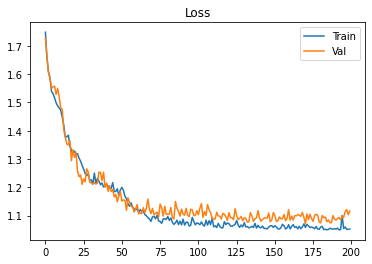

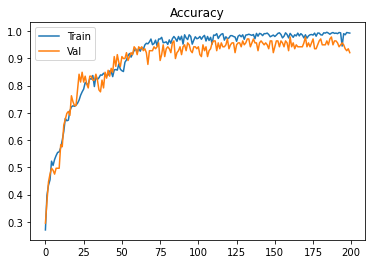

In [11]:
plt.figure(1)
plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)
plt.title("Loss")
plt.legend(("Train", "Val"))

plt.figure(2)
plt.plot(epoch_train_accuracy)
plt.plot(epoch_val_accuracy)
plt.title("Accuracy")
plt.legend(("Train", "Val"))

In [12]:
max(epoch_val_accuracy)

tensor(0.9784, device='cuda:0')